Compares tracer values from different areas to determine if they are statistically different

In [1]:
from chem_ocean import ocean_data as oc_data
import chem_ocean.ocean_analysis as oc_an
import chem_ocean.ocean_plt as oc_plt

from chem_ocean.ocean_plt_util import make_section, subplot_labels

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from scipy import stats

In [2]:
path = 'watermass_diff_plts/'

select station, longitude, latitude, depth, nitrate from woa13 where latitude> -40 AND latitude< -38 AND longitude>-30 and longitude<-28;
dict_keys(['station', 'longitude', 'latitude', 'depth', 'nitrate'])
select station, longitude, latitude, depth, nitrate from woa13 where latitude> -70 AND latitude< 0 AND longitude>-33.5 and longitude<-30.5;


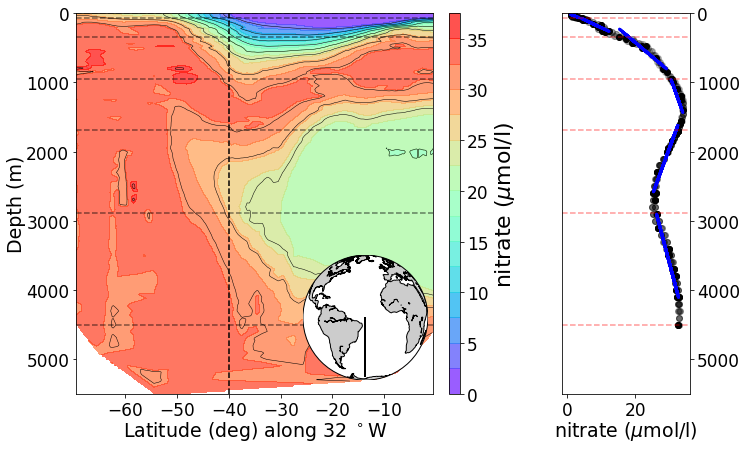

In [37]:
# Break water column into statistically different watermasses by regressing
# sections of the slope of at least 60 data points. as long as the r**2 is increasing, 
# expand the intervale by 5 meters. When the r**2 value begins to decline save the depth 
# and start a new section

minlat, minlon = -40, -30
# # only profile 
_x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = oc_data.get_column([minlat, minlat+2], [minlon, minlon+2], ['nitrate'])
# intervals, fig, ax2 = oc_an.column_split_byslope(_feat_data, _d)

# profile with section
fig, (ax1, ax2) = oc_plt.plotRaw(-70, 0, -32, -32, ['nitrate'], 'NS_section', add_profile = True)
intervals, fig, ax2 = oc_an.column_split_byslope(_feat_data, _d, exist_plt = (fig, ax2), depth_lim = ax1.get_ylim())

# add annotation from profile to section plot
ax1.axvline(minlat, color='k', linestyle='--')
for depth in intervals:
    ax1.axhline(depth, color='k', linestyle='--', alpha = .5)
    
plt.savefig(path+'nitrate_section_70-0s32w_columnwslope_40s30w.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

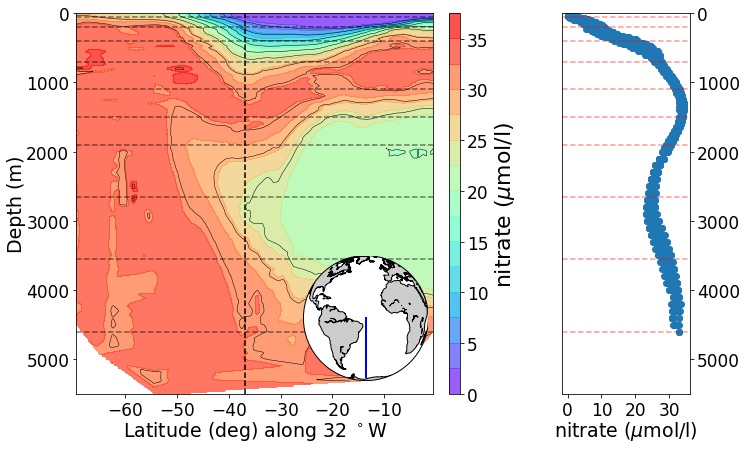

In [28]:
#Find depths of statistically different water masses by 1 tracer
# Assumes miniumum sample size of 200 of both samples
# starts from the bottom and if the samples between bottom bound and middle bound 
# are not statistically different from the sample between middle bound and upper bound,
# push the middle bound and upper bound up and try again
# once they are stastistically different drop the middle bound incrementally until reach the 
# depth where the p value is just less than .01
# then set bottom bound = middle bound and repeat
tracer = 'nitrate'
minlat, maxlat, minlon, maxlon = -40, -35,-30, -25
slice_type = 'column'
notes = 'ptest'
_x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = oc_data.get_column([minlat, maxlat], [minlon, maxlon], [tracer])
name1 = save_name(tracer, slice_type, minlat, maxlat, minlon, maxlon, note= notes)


# profile with section
tracer = 'nitrate'
minlat, maxlat, minlon, maxlon = -70, 0, -32, -32
slice_type = 'section'
notes = ''
fig, (ax1, ax2) = oc_plt.plotRaw(-70, 0, -32, -32, ['nitrate'], 'NS_section', add_profile = True)
intervals, fig, ax2 = oc_an.column_split_ptest(_feat_data, _d, exist_plt = (fig, ax2), depth_lim = ax1.get_ylim())
name2 = save_name(tracer, slice_type, minlat, maxlat, minlon, maxlon, note= notes)

minlat = -37
# add annotation from profile to section plot
ax1.axvline(minlat, color='k', linestyle='--')
for depth in intervals:
    ax1.axhline(depth, color='k', linestyle='--', alpha = .5)
    
name = name1+'_'+name2+'.png'
# intervals, fig, ax2 = oc_an.column_split_ptest(_feat_data, _d)
plt.savefig(path+name, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

98.831846093
-89.7600119994 2.34734921973e-100
p-value is so small that there is only a miniscule chance that these two samples could have been picked from the same population


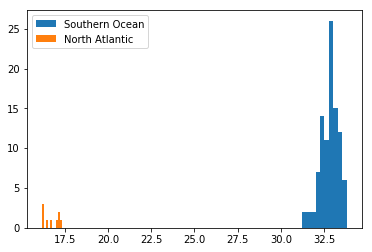

In [7]:
# Considering nitrate values from the North Atlantic and the South Atlantic

_x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = oc_data.get_plan([-70,-50], [-40,-30], ['nitrate'], 4000)
data_s = _feat_data

_x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = oc_data.get_plan([50,70], [-40,-30], ['nitrate'], 4000)
data_n = _feat_data

y_mean = np.mean(data_s) -np.mean(data_n)
std_error = (np.std(data_s)**2/(len(data_s)-1) + np.std(data_n)**2/(len(data_n)-1))**(.5)
t_score = y_mean/std_error
print(t_score) #why is this different from the scipy value?

#p-value after comparison with the t 
t2, p2 = stats.ttest_ind(data_n,data_s)

print(t2, p2)

plt.hist(data_s, label = 'Southern Ocean')
plt.hist(data_n, label = 'North Atlantic')

# oceans = ['Southern Ocean', 'North Atlantic']
# ax0.hist(x, n_bins, density=True, histtype='bar', label=oceans)
plt.legend(prop={'size': 10})


print('p-value is so small that there is only a miniscule chance that these two samples could have been picked from the same population')

name = save_name('nitrate', 'plan', -70,-50, -40,-30, two_loc = (50,70,-40,-30), depth = 4000, note='ptest')

plt.savefig(path+name+'.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

In [26]:
def save_name(tracer, slice_type, minlat, maxlat, minlon, maxlon, **kwargs):
    
    def latlon_fn(minlat, maxlat, minlon, maxlon):
        if maxlat<0:
            lat = str(abs(min(minlat, maxlat)))+':'+str(abs(max(minlat, maxlat)))+'s'
        else:
            if minlat<0:
                lat = str(abs(minlat))+'s'+':'+str(abs(maxlat))+'n'
            else:
                lat = str(abs(min(minlat, maxlat)))+':'+str(abs(max(minlat, maxlat)))+'n'

        if maxlon<0:
            lon = str(abs(min(minlon, maxlon)))+':'+str(abs(max(minlon, maxlon)))+'w'
        else:
            if minlon<0:
                lon = str(abs(minlon))+'w'+':'+str(abs(maxlon))+'e'
            else:
                lon = str(abs(min(minlon, maxlon)))+':'+str(abs(max(minlon, maxlon)))+'e'

        return lat+'-'+lon       
    if 'two_loc' in kwargs:
        latlon1 = latlon_fn(minlat, maxlat, minlon, maxlon)
        (minlat, maxlat, minlon, maxlon) = kwargs['two_loc']
        latlon2 = latlon_fn(minlat, maxlat, minlon, maxlon)
        latlon = '_'+latlon1+'_and_'+latlon2
    else:
        latlon = '_'+latlon_fn(minlat, maxlat, minlon, maxlon)
        
    if 'depth' in kwargs:
        depth = '_'+str(kwargs['depth'])+'m'
    else:
        depth = ''
        
    if 'note' in kwargs:
        note = '_'+kwargs['note']
    else:
        note = ''
    
    return tracer+'_'+slice_type+latlon+depth+note

In [19]:
save_name('nitrate', 'plan', -70,-50, -40,-30, two_loc = (50,70,-40,-30), depth = 4000, note='ptest')

'nitrate_plan_70:50s-40:30w_and_50:70n-40:30w_4000m_ptest'